In [1]:

from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrogram as spectrogram
import spectrum_painting as sp
import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training
from save_iq_data_for_arduino import save_iq_data

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Convert MATLAB data to numpy files to make loading quicker

See `convert_matlab_to_numpy.py` to do call this manually without running it in the notebook.

# Load spectrograms

In [73]:
reload(sp_training)

classes = ["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"]
# classes = ["ZBW"]
spectrum_painting_options = sp_training.SpectrumPaintingTrainingOptions(
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

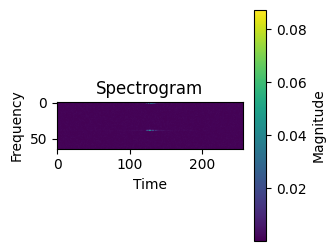

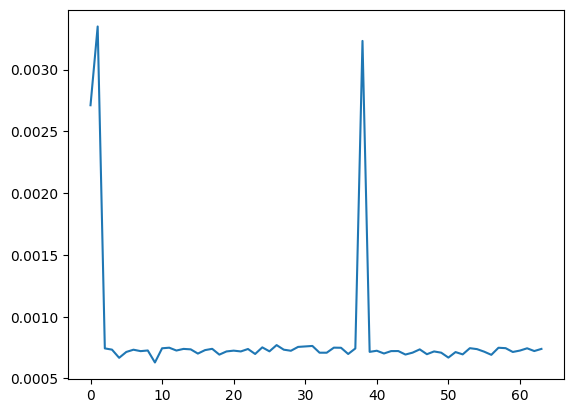

In [74]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you wrote.
reload(spectrogram)
reload(sp)
reload(sp_data)

spectrograms = sp_data.load_spectrograms(data_dir="data/numpy",
                                         classes=classes,
                                         snr_list=[10],
                                         windows_per_spectrogram=64,
                                         window_length=6000,
                                         nfft=256)

sp_plot.plot_spectrogram(spectrograms[10][0].values)
plt.plot(np.mean(spectrograms[10][0].values, axis=1))
plt.show()

In [75]:
reload(sp)
reload(spectrogram)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=spectrum_painting_options,
    test_size=0.3
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")

Removed 86 images that didn't actually contain any Bluetooth signals.
Number of training images: 1259
Number of testing images: 540


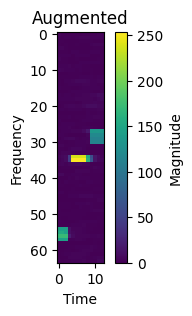

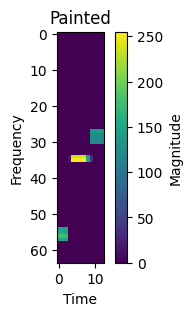

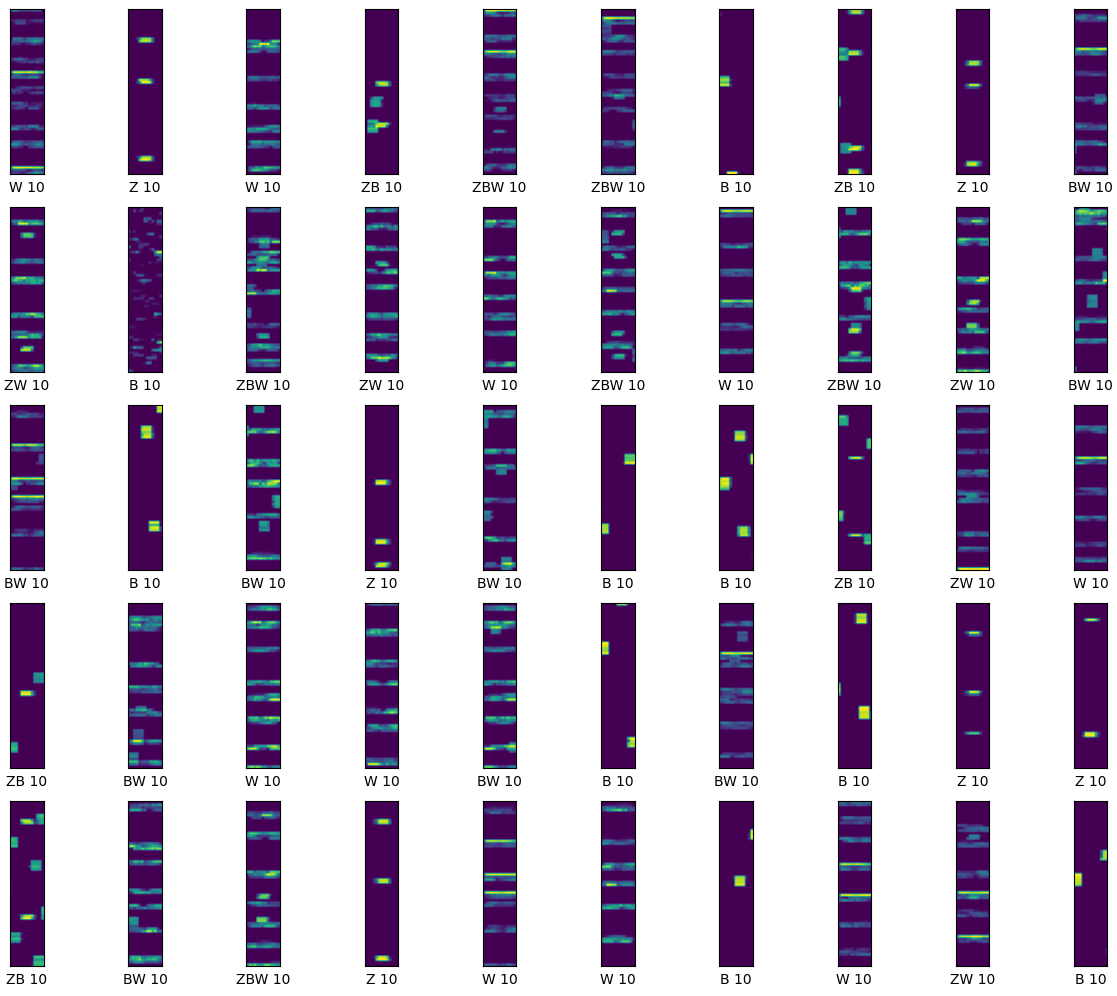

In [76]:
image_index = 30
sp_plot.plot_spectrogram(train_test_sets.x_test_augmented[image_index], "Augmented")
sp_plot.plot_spectrogram(train_test_sets.x_test_painted[image_index], "Painted")

sp_plot.plot_train_images(train_test_sets.x_test_painted,
                          train_test_sets.y_test,
                          train_test_sets.label_names,
                          train_test_sets.test_snr)

# Create TensorFlow model

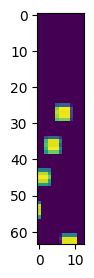

(64, 13)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 13, 8)            400       ['input_3[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 64, 13, 8)            400       ['input_4[0][0]']             
                                                                                   

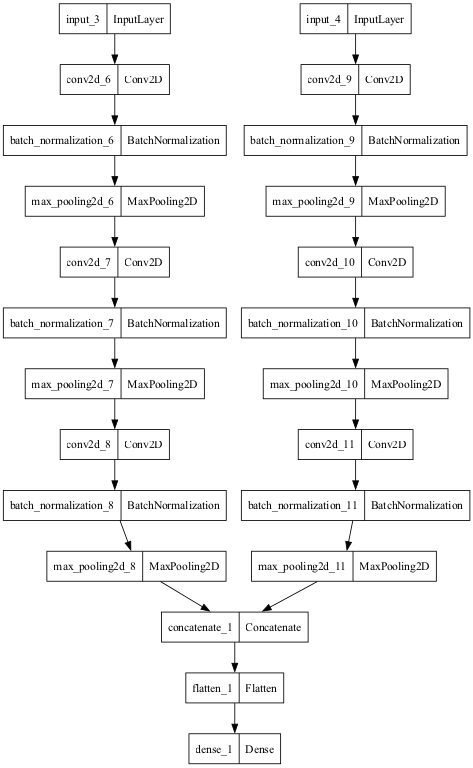

In [24]:
reload(sp_model)

plt.figure(figsize=(3, 3))
plt.imshow(train_test_sets.x_test_painted[0], cmap='viridis')
plt.show()

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape=image_shape, label_count=len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


# Train the TensorFlow model

 Epoch: 114, Val. accuracy = 0.8968609571456909

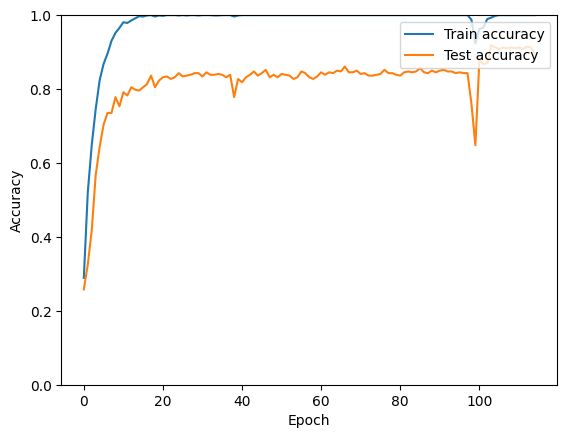

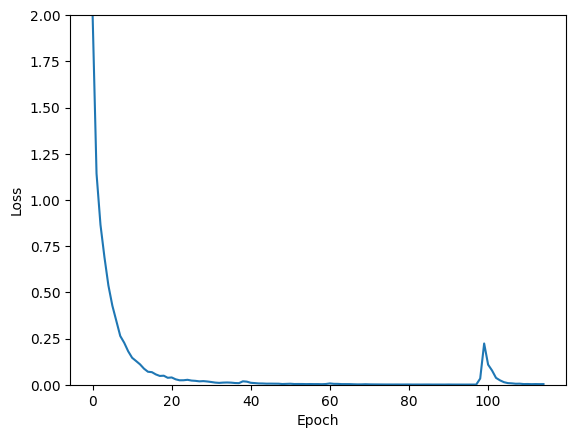

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


Final loss: 0.296190, final accuracy: 0.896861


In [25]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=200, early_stopping_patience=20)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

output_file = f"output/spectrum-painting-model-SNR-10.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented, train_test_sets.x_test_painted],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


# Confusion matrix for TensorFlow model

In [ ]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

sp_plot.plot_spectrogram(test_img_augmented, "Augmented")
sp_plot.plot_spectrogram(test_img_painted, "Painted")

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

# Convert to Lite model

In [ ]:
reload(sp_model)
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model,
                                                   train_test_sets.x_test_augmented,
                                                   train_test_sets.x_test_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

lite_output_file = f"output/spectrum-painting-model.tflite"
# Save the model.
with open(lite_output_file, "wb") as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i $lite_output_file | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

In [ ]:
reload(sp_predict)
image_index = 20

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

sp_plot.plot_spectrogram(test_img_augmented, "Augmented")
sp_plot.plot_spectrogram(test_img_painted, "Painted")
print(train_test_sets.label_names[train_test_sets.y_test[image_index]])

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

# Confusion matrix for Lite model

In [ ]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions),
                              train_test_sets.y_test,
                              train_test_sets.label_names)

# Save IQ data to the arduino

In [ ]:
iq_data = data = np.load(f"data/numpy/SNR10_ZBW.npy")

save_iq_data(iq_data, windows=64, window_length=4096, file="../arduino/spectrum_painting/data.h")

# Compile and upload to arduino

In [ ]:
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem2101

In [ ]:
serial = Serial(port="/dev/cu.usbmodem2101", baudrate=115200, timeout=1000)

arduino_spectrogram = []
for _ in range(spectrum_painting_options.downsample_resolution):
    real_line = serial.readline().decode('utf-8').strip()
    magnitudes = list(map(float, real_line.split(',')))

    arduino_spectrogram.append(magnitudes)

downsample_duration = int(serial.readline().strip())
augment_duration = int(serial.readline().strip())
paint_duration = int(serial.readline().strip())
inference_duration = int(serial.readline().strip())
total_duration = int(serial.readline().strip())
predicted_label = int(serial.readline().strip())

sp_plot.plot_spectrogram(np.asarray(arduino_spectrogram), "Arduino spectrogram")

print(f"Downsample duration = {downsample_duration} ms")
print(f"Augment duration = {augment_duration} ms")
print(f"Paint duration = {paint_duration} ms")
print(f"Inference duration = {inference_duration} ms")
print(f"Total duration = {total_duration} ms")
print(f"Predicted label = {classes[predicted_label]}")

serial.close()